In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv

import time

from source.mesh import Mesh
from source.integrators import ElementIntegratorCollocation
from source.matrix_assembly import CollocationAssembler
from source.solve import BEMSolver

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
def icosahedron():
    t = (1.0 + np.sqrt(5.0)) / 2.0
    V = np.array([
        [-1,  t, 0],
        [ 1,  t, 0],
        [-1, -t, 0],
        [ 1, -t, 0],
        [ 0, -1,  t],
        [ 0,  1,  t],
        [ 0, -1, -t],
        [ 0,  1, -t],
        [ t,  0, -1],
        [ t,  0,  1],
        [-t,  0, -1],
        [-t,  0,  1],
    ], dtype=float)
    V /= np.linalg.norm(V, axis=1)[:, None]
    F = np.array([
        [0, 11, 5], [0, 5, 1], [0, 1, 7], [0, 7,10], [0,10,11],
        [1, 5, 9], [5,11, 4], [11,10,2], [10,7,6], [7, 1, 8],
        [3, 9, 4], [3, 4, 2], [3, 2, 6], [3, 6, 8], [3, 8, 9],
        [4, 9, 5], [2, 4,11], [6, 2,10], [8, 6, 7], [9, 8, 1]
    ], dtype=int)
    return V, F

def subdivide_sphere(V, F, levels=1):
    """Loop-subdivide each triangle and re-project to unit sphere."""
    for _ in range(levels):
        mid_cache = {}
        newF = []
        def midpoint(i, j):
            key = tuple(sorted((i, j)))
            if key in mid_cache: return mid_cache[key]
            m = (V[i] + V[j]) * 0.5
            m = m / np.linalg.norm(m)
            idx = len(V_list)
            V_list.append(m)
            mid_cache[key] = idx
            return idx
        V_list = [v.copy() for v in V]
        for a,b,c in F:
            ab = midpoint(a,b)
            bc = midpoint(b,c)
            ca = midpoint(c,a)
            newF += [
                [a, ab, ca],
                [b, bc, ab],
                [c, ca, bc],
                [ab, bc, ca],
            ]
        V = np.asarray(V_list)
        F = np.asarray(newF, dtype=int)
    return V, F

### Uncomment to visualize the mesh
# a = 0.075              # sphere radius [m]
# subdiv = 3
# V, F = icosahedron()
# V, F = subdivide_sphere(V, F, levels=subdiv)
# V = a * V

# pl = pv.Plotter()
# pv_mesh = pv.PolyData(V, np.hstack([np.full((F.shape[0],1),3), F]))
# pl.add_mesh(pv_mesh, show_edges=True)
# pl.show()

In [64]:
def analytic_phi_pulsating_sphere(r: np.ndarray, 
                                  a: float, 
                                  k: float, 
                                  Vn: complex) -> np.ndarray:
    """Analytical exterior potential for a uniformly pulsating sphere.

    Args:
        r (np.ndarray): Radial distances where to evaluate, shape (M,).
        a (float): Sphere radius.
        k (float): Wavenumber (omega / c0).
        Vn (complex): Uniform radial surface velocity.

    Returns:
        np.ndarray: Potential phi(r), shape (M,), complex.
    """
    A = Vn * a*a / (1j*k*a - 1.0)
    return A * np.exp(1j*k*(r - a)) / r

In [71]:
# Field point array
plane_extent = 1
plane_pts = 200

# mesh and conditions setup
frequency = 1000                       # frequency [Hz]
c0 = 343                               # speed of sound [m/s]
omega = 2 * np.pi * frequency          # angular frequency [rad/s]
k = omega / c0                         # wavenumber [rad/m]
rho0 = 1.225                           # density of air [kg/m^3]

radius = 0.075                         # radius of pulsating sphere [m]
Vn = 1.0 + 0j                          # normal velocity on sphere surface [m/s]
subdiv = 3                             # mesh subdivision level
nodes, elements = icosahedron()
nodes, elements = subdivide_sphere(nodes, elements, levels=subdiv)
nodes *= radius

vel_BC = np.ones(nodes.shape[0]) * Vn

print(f"Mesh: {nodes.shape[0]} nodes, {elements.shape[0]} elements.")

Mesh: 642 nodes, 1280 elements.


In [72]:
# Init package objects

mesh = Mesh(nodes, elements, vel_BC, frequency, c0, rho0)
integrator = ElementIntegratorCollocation(k = mesh.k)
assembler = CollocationAssembler(mesh, integrator)
solver = BEMSolver(assembler=assembler)

In [11]:
t_start = time.time()
print("Assembling matrices...")
mats = {
    "S": assembler.assemble("S"),
    "D": assembler.assemble("D"),
    # Kp and N not needed for this solve
}
t_assembly = time.time()
print(f"  ... done in {t_assembly - t_start:.2f} s.")

# --- solve BIE for Neumann BC (normal velocity) ---
print("Solving BIE...")
q_bc = np.full(mesh.num_nodes, Vn, dtype=complex)
phi_bnd = solver.solve_direct("Neumann", q_bc, mats)
t_solve = time.time()
print(f"  ... done in {t_solve - t_assembly:.2f} s.")

# --- Build evaluation grid in x–z plane ---
xs = np.linspace(-plane_extent, plane_extent, plane_pts)
zs = np.linspace(-plane_extent, plane_extent, plane_pts)
XX, ZZ = np.meshgrid(xs, zs)
YY = np.zeros_like(XX)

field_pts = np.column_stack([XX.ravel(), YY.ravel(), ZZ.ravel()])


# --- Evaluate **potential** then convert to pressure
print("Evaluating field...")
phi_field = solver.evaluate_field(field_pts, phi=phi_bnd, q=q_bc, quad_order=3)
p_field = 1j * omega * rho0 * phi_field
P_grid = p_field.reshape(XX.shape)
t_evaluate = time.time()
print(f"  ... done in {t_evaluate - t_solve:.2f} s.")

Assembling matrices...
  ... done in 46.22 s.
Solving BIE...
  ... done in 0.07 s.
Evaluating field...
  ... done in 36.49 s.


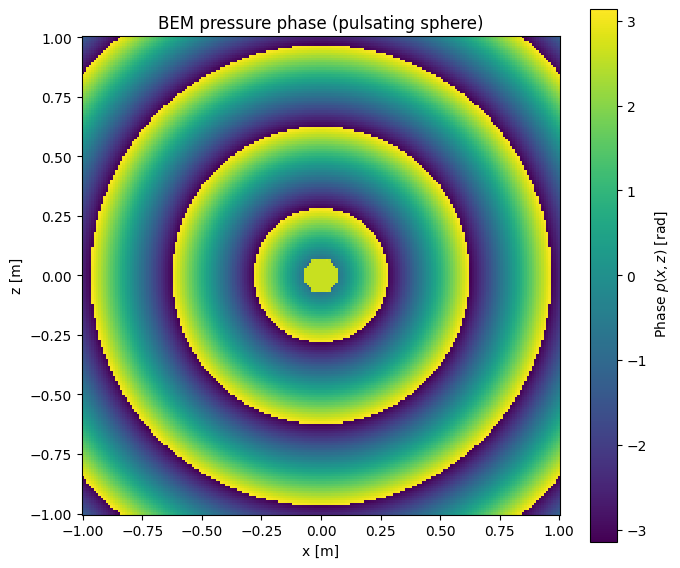

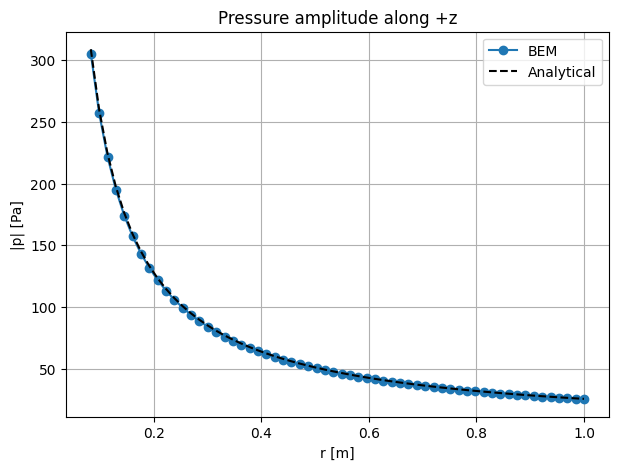

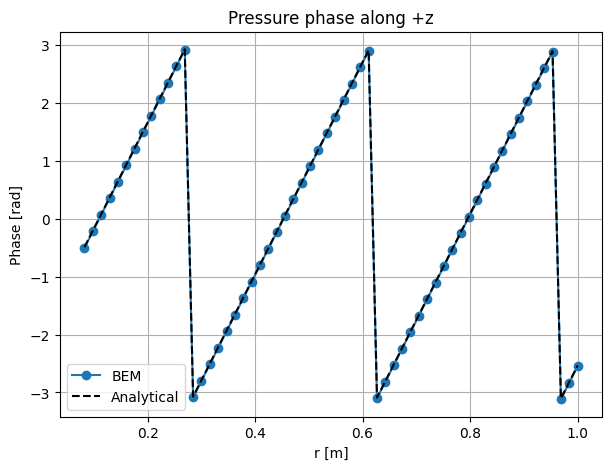

In [16]:
# --- Plot 2D heatmap of |p| ---
plt.figure(figsize=(7, 6))
plt.pcolormesh(XX, ZZ, np.angle(P_grid), shading="auto", cmap="viridis")
plt.colorbar(label=r" Phase $p(x,z)$ [rad]")
plt.xlabel("x [m]")
plt.ylabel("z [m]")
plt.title("BEM pressure phase (pulsating sphere)")
plt.gca().set_aspect("equal")
plt.tight_layout()

# --- 1D comparison along +z axis ---
rs = np.linspace(1.1 * radius, plane_extent, 60)
pts_line = np.column_stack([np.zeros_like(rs),
                            np.zeros_like(rs),
                            rs])
phi_line = solver.evaluate_field(pts_line, phi=phi_bnd, q=q_bc, quad_order=7)
p_line = 1j * omega * rho0 * phi_line

p_ref = 1j * omega * rho0 * analytic_phi_pulsating_sphere(rs, radius, k, Vn)

# Amplitude
plt.figure(figsize=(7, 5))
plt.plot(rs, np.abs(p_line), "o-", label="BEM")
plt.plot(rs, np.abs(p_ref), "k--", label="Analytical")
plt.xlabel("r [m]")
plt.ylabel("|p| [Pa]")
plt.title("Pressure amplitude along +z")
plt.legend()
plt.grid(True)

# Phase
plt.figure(figsize=(7, 5))
plt.plot(rs, np.angle(p_line), "o-", label="BEM")
plt.plot(rs, np.angle(p_ref), "k--", label="Analytical")
plt.xlabel("r [m]")
plt.ylabel("Phase [rad]")
plt.title("Pressure phase along +z")
plt.legend()
plt.grid(True)

plt.show()